In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load received SQLite file: database.db <br> 2. The database.db file contains several tables. Use them to create Pandas DataFrame with x , y , z , color_id and color_name for every record.

In [2]:
query = (
    """SELECT 
    data.id, x, y, z, connection_id AS color_id, name AS color_name 
    FROM data 
    LEFT JOIN connection 
    ON data.connection_id=connection.id"""
)

with sqlite3.connect('database_1.db') as con:
    df = pd.read_sql_query(query, con, index_col='id')

# 3. Note, that x, y, z should be converted to floating-point format (if necessary), and color_id to integers. <br> 4. All invalid record should be removed.

In [3]:
df[['x', 'y', 'z', 'color_id']] = df[['x', 'y', 'z', 'color_id']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(axis=0)
df[['x', 'y', 'z']] = df[['x', 'y', 'z']].astype('float64')
df['color_id'] = df['color_id'].astype('int64')

# 5. Change color_name column to color

In [4]:
df = df.rename(columns={'color_name':'color'})

# 6. List unique color values.

In [5]:
print(df['color'].unique())

['green' 'orange' 'yellow' 'red' 'black' 'blue']


# 7. Leave only data with z = 100

In [6]:
df = df[df['z'] == 100]

# 8. Remove red points with a distance from average red points’ position above 1 sigma.

In [29]:
red = df[df['color'] == 'red']
red_sigma = red[['x', 'y']].apply(np.linalg.norm, axis=1).std()
red_mean = np.mean(red[['x', 'y']], axis=0)
cond = (np.linalg.norm(df[['x', 'y']].values-red_mean.values, axis=1) > red_sigma)
df = df[~(cond & (df['color'] == 'red'))]

# 9. Make sure rows indices are consecutive integers (starting from 0).

In [30]:
df = df.reset_index(drop=True)

# 10. Save the remaining points in a HDF5 file with dataset ns1 containing columns: x, y, color

In [31]:
columns = ['x', 'y', 'color']

hdf = pd.HDFStore('dataset.h5')
hdf.put('ns1', df[columns], format='table', data_columns=True)

# 11. Plot data from the HDF5 file using scatter plot (with corresponding colors) <br> 12. Add above plot to repository (as separate png file or as notebook cell output)

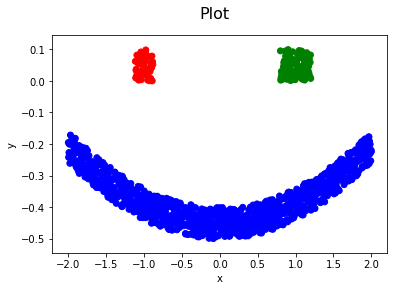

In [44]:
fig, ax = plt.subplots(1,1)
ax.scatter(hdf['ns1']['x'], hdf['ns1']['y'], c=hdf['ns1']['color'])
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.suptitle('Plot', fontsize=16)

fig.savefig('plot.png', dpi=300)